In [1]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import train_and_eval, count_parameters, summarize_results, load_experiment_log, \
    plot_single_learning_curve, plot_multiple_learning_curves
import pickle as pkl 
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# params required for generating data loaders 

SRC_LANG = 'vi'
TARG_LANG = 'en'

SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

BATCH_SIZE = 64 

In [3]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [4]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [5]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [6]:
# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0
DEC_DROPOUT = 0
ATTENTION_TYPE = 'additive'

# training params  
NUM_EPOCHS = 5
LR = 0.0003 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model and experiment 
EXPERIMENT_NAME = 'hyperparameter_tuning_attention_type'
if NETWORK_TYPE == 'rnn': 
    MODEL_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    MODEL_NAME = '{}-cnn'.format(SRC_LANG)

In [7]:
# store as dict to save to results later 
params = {'experiment_name': EXPERIMENT_NAME,'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'rnn_cell_type': RNN_CELL_TYPE, 'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 
          'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 'src_vocab_size': SRC_VOCAB_SIZE, 
          'targ_vocab_size': TARG_VOCAB_SIZE, 'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 
          'dec_hidden_dim': DEC_HIDDEN_DIM, 'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 
          'clip_grad_max_norm': CLIP_GRAD_MAX_NORM, 'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'attention_type': ATTENTION_TYPE, 'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 
          'learning_rate': LR, 'optimizer': OPTIMIZER, 'lazy_train': LAZY_TRAIN} 

In [12]:
# for candidate in ['multiplicative', 'additive']: 

for candidate in ['additive']: 
    
    print("Training with attention_type = {}".format(candidate))
    
    # overwrite relevant key-value in params 
    params['attention_type'] = candidate 
    params['model_name'] = '{}-rnn-{}-attn-tuning'.format(SRC_LANG, candidate)
    
    # instantiate model 
    encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                         src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                         pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                             num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=DEC_DROPOUT, attention_type=candidate,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 
    
    # train and eval 
    model, results = train_and_eval(
        model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
        params=params, vocab=vocab, print_intermediate=500, save_checkpoint=True, save_to_log=True, 
        lazy_eval=True, print_attn=False, inspect_samples=3)

Training with attention_type = additive
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.25, Train BLEU: 0.00, Val BLEU: 0.06, Minutes Elapsed: 0.10
Sampling from val predictions...
Source: và câu trả_lời đầu_tiên của tôi là : " chị
Reference: and the first answer is , &quot; i don
Model: <SOS> and and of the the the the the the

Source: những chúng mang hai_nghĩa khác_biệt . <EOS> <PAD> <PAD> <PAD>
Reference: but they mean two different things . <EOS> <PAD>
Model: <SOS> and and a the the the the the the

Source: và thật_sự , kết_luận đưa ra từ nghiên_cứu này là
Reference: so actually , the conclusion from this research is
Model: <SOS> and and the the the the the the the



Epoch: 0.24, Train Loss: 0.00, Val Loss: 6.01, Train BLEU: 0.00, Val BLEU: 1.75, Minutes Elapsed: 8.69
Sampling from val predictions...
Source: đó có nghĩa_là nó có_thể tự thực_hiện được . <EOS>
Reference: that means they can be <UNK> . <EOS> <PAD>
Model: <SOS> it &apos;s is a a . . . .

Source: cho đến tháng ba , 2011 , tôi làm thợ
Reference: before march , 2011 , i was a photographic
Model: <SOS> but , , , , , , , ,

Source: đứa trẻ này 8 tuổi . <EOS> <PAD> <PAD> <PAD>
Reference: this young child is eight years old . <EOS>
Model: <SOS> it &apos;s . . . . . <EOS> <EOS>



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.36, Train BLEU: 0.00, Val BLEU: 4.93, Minutes Elapsed: 17.48
Sampling from val predictions...
Source: vậy_là chúng_ta có nhựa_đường trộn với những vụn thép rất
Reference: so then you have asphalt with very small pieces
Model: <SOS> we we we we to the the of the

Source: một_số nơi tôi coi_như nhà mình . <EOS> <PAD> <PAD>
Reference: some i even considered like my second home .
Model: <SOS> my , i me . . . . .

Source: nhiếp_ảnh là niềm đam_mê của tôi kể từ khi tôi
Reference: photography has been my passion ever since i was
Model: <SOS> the is is my my i i i i



Epoch: 0.72, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 8.10, Minutes Elapsed: 26.53
Sampling from val predictions...
Source: cuối_cùng thì sáng_kiến của chúng_tôi cũng đã được tiếp_nhận và
Reference: eventually , our initiative was adopted and successful .
Model: <SOS> the the the the is the and and are

Source: <UNK> tin_tưởng tôi , như một nhà_văn và một phụ_nữ
Reference: <UNK> believed in me , as a writer and
Model: <SOS> my <UNK> , , , a a a ,

Source: bấy_giờ , tất_cả những hình_ảnh này đã bị nước làm
Reference: now , all these photos had been damaged by
Model: <SOS> now , the are all are the to to



Epoch: 0.96, Train Loss: 0.00, Val Loss: 4.74, Train BLEU: 0.00, Val BLEU: 8.58, Minutes Elapsed: 35.59
Sampling from val predictions...
Source: câu_chuyện bắt_đầu khi tôi đến thành_phố new_york để tham_gia vào
Reference: my story begins when i was in new york
Model: <SOS> i i i i i was to to to

Source: một slide như thế này , không_những nhàm_chán mà_còn phụ_thuộc
Reference: a slide like this is not only boring ,
Model: <SOS> a a of , , , , , ,

Source: các chiến_binh masai người bảo_vệ cộng_đồng chúng_tôi và gia_súc ,
Reference: the <UNK> are the warriors who protect our community
Model: <SOS> the are , , in and and and and



Epoch: 1.00, Train Loss: 0.00, Val Loss: 4.74, Train BLEU: 0.00, Val BLEU: 8.76, Minutes Elapsed: 37.17
Sampling from val predictions...
Source: tôi sống ở vùng trung nam . <EOS> <PAD> <PAD>
Reference: i live in south central . <EOS> <PAD> <PAD>
Model: <SOS> i &apos;m in in in the . <EOS> <EOS>

Source: không_ai khởi_đầu một công_ty một_mình . không_ai cả . <EOS>
Reference: nobody started a company alone . no one .
Model: <SOS> not &apos;s not a . . . . .

Source: không_ai khởi_đầu một công_ty một_mình . không_ai cả . <EOS>
Reference: nobody started a company alone . no one .
Model: <SOS> not &apos;s not a . . . . .



Epoch: 1.24, Train Loss: 0.00, Val Loss: 4.57, Train BLEU: 0.00, Val BLEU: 10.85, Minutes Elapsed: 46.10
Sampling from val predictions...
Source: bảo_hộ , là tôi đối_xử với bất_cứ người nào đến
Reference: <UNK> , i treat anybody from a different culture
Model: <SOS> so , i i to some all . .

Source: khi mà những quả cà_chua bắt_đầu đạt , chín ,
Reference: when the tomatoes were nice and ripe and red
Model: <SOS> when you &apos;re was the , , , ,

Source: họ là những luật_sư , nhà_báo và cả những <UNK>
Reference: they were lawyers , journalists , priests , they
Model: <SOS> they are the , and and and and and



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.44, Train BLEU: 0.00, Val BLEU: 11.15, Minutes Elapsed: 55.02
Sampling from val predictions...
Source: tôi là một đứa trẻ của năm 1984 , và
Reference: i &apos;m a child of 1984 , and i
Model: <SOS> i was a of of , , , ,

Source: chà , tôi không_thể phủ_nhận rằng đã có một_vài khoảnh_khắc
Reference: now , i cannot deny that there have been
Model: <SOS> well , i can &apos;t that that was a

Source: tôi đã nghĩ chỉ có mỗi người ý là khờ_khạo
Reference: i thought it was only us italians <UNK> around
Model: <SOS> i thought there have only to to the the



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.33, Train BLEU: 0.00, Val BLEU: 11.88, Minutes Elapsed: 63.95
Sampling from val predictions...
Source: và làm thế_nào chúng_ta chia_sẻ nhiều hơn những hy_vọng của
Reference: and how can we share more of our hopes
Model: <SOS> and how do we to more more of of

Source: tôi hi_vọng những tấm hình sẽ đánh_thức một nguồn sức_mạnh
Reference: i hope that these images awaken a force in
Model: <SOS> i decided the to will will a a of

Source: và trong năm 1860 , nhóm người ngày tụ_họp lại
Reference: and in <UNK> , this group of people came
Model: <SOS> and in , , , people of the of



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.25, Train BLEU: 0.00, Val BLEU: 12.89, Minutes Elapsed: 72.80
Sampling from val predictions...
Source: " vừa kịp lúc để cứu người zambia khỏi nạn
Reference: &quot; just in the nick of time to save
Model: <SOS> &quot; it , to to to to in the

Source: vì_thế tôi đã có một ý_tưởng . <EOS> <PAD> <PAD>
Reference: so i had an idea . <EOS> <PAD> <PAD>
Model: <SOS> so i had a idea . <EOS> . <EOS>

Source: đừng hiểu_lầm tôi . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: now don &apos;t get me wrong . <EOS> <PAD>
Model: <SOS> don don my &apos;t me . <EOS> <EOS> <EOS>



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.28, Train BLEU: 0.00, Val BLEU: 12.31, Minutes Elapsed: 74.36
Sampling from val predictions...
Source: nhưng không có ai giúp họ , bởi_vì tất_cả đều
Reference: but nobody helped them , because they were so
Model: <SOS> but no people &apos;t , them , , all

Source: khi một bức ảnh như thế_này được đem trả_lại ,
Reference: when a photo like this can be returned to
Model: <SOS> when a was of a world a a of

Source: bởi_vì dù chúng_tôi chụp cùng một bức ảnh , nhưng
Reference: because while we take the same photo , our
Model: <SOS> because we we we to a of , a



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.21, Train BLEU: 0.00, Val BLEU: 13.35, Minutes Elapsed: 83.15
Sampling from val predictions...
Source: tôi đã từng ghét sư_tử , nhưng bây_giờ bởi_vì phát_minh
Reference: i used to hate lions , but now because
Model: <SOS> i was been , , but but i was

Source: nhựa_đường xốp là vật_liệu chúng_tôi hiện đang dùng để xây_dựng
Reference: porous asphalt , a material that we use now
Model: <SOS> the are the the we are we &apos;re working

Source: chúng cũng đã bị liên_kết với disney - - bị
Reference: they &apos;ve also be associated with disney — —
Model: <SOS> they also also been with with with -- --



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.14, Train BLEU: 0.00, Val BLEU: 13.94, Minutes Elapsed: 92.01
Sampling from val predictions...
Source: đúng vậy đấy , gần như_là tất_cả các tấm ảnh
Reference: and yeah , they pretty much <UNK> all the
Model: <SOS> right , , all all all the the <EOS>

Source: tại_sao xã_hội chúng_tôi tiếp_tục là một xã_hội phân_cực và thống_trị
Reference: why does our society continue to be polarized and
Model: <SOS> why do we we is a a social opportunity

Source: bởi_vì hoà_bình như thuật giả kim , nó cần đến
Reference: for peace has an alchemy , and this alchemy
Model: <SOS> because it , or , , it it it



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 13.90, Minutes Elapsed: 100.87
Sampling from val predictions...
Source: nhưng tôi không từ_bỏ . tôi tiếp_tục suy_nghĩ . <EOS>
Reference: so i didn &apos;t give up . i continued
Model: <SOS> but i &apos;m &apos;t . . . i &apos;m

Source: bởi sự_thật tôi là một nạn_nhân điển_hình của bạo_lực gia_đình
Reference: because it turns out that i &apos;m actually a
Model: <SOS> because i i a a a a a of

Source: tôi luôn là người chụp ảnh . <EOS> <PAD> <PAD>
Reference: i &apos;m always the one taking the picture .
Model: <SOS> i &apos;m always the the . . . .



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 14.12, Minutes Elapsed: 109.70
Sampling from val predictions...
Source: ước_mơ lớn nhất của tôi là trở_thành một kỹ_sư máy_bay
Reference: so my big dream is to become an aircraft
Model: <SOS> my first my is is a a a a

Source: nhiều phụ_nữ địu con trên lưng trong_khi đãi vàng ,
Reference: many women had children strapped to their backs while
Model: <SOS> many of women in in their the , ,

Source: tôi thực_sự tin , nếu ta coi người khác như
Reference: i truly believe , if we can see one
Model: <SOS> i i believe if if we look somebody other



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.12, Train BLEU: 0.00, Val BLEU: 13.54, Minutes Elapsed: 111.27
Sampling from val predictions...
Source: với một cộng_đồng 10,000 người , chúng_ta có_thể có khoảng
Reference: in a community of 10,000 people , we get
Model: <SOS> with a community community , , , we can

Source: thay vào đó , như anh - <UNK> đã nói
Reference: instead , as einstein said , make everything as
Model: <SOS> instead , , he , , he said ,

Source: tôi là một đứa trẻ của năm 1984 , và
Reference: i &apos;m a child of 1984 , and i
Model: <SOS> i &apos;m a of of , , and and



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 14.03, Minutes Elapsed: 120.07
Sampling from val predictions...
Source: và một_vài người thậm_chí đã nói , nó giống_như <UNK>
Reference: and some even said , this would be <UNK>
Model: <SOS> and some people people say , , like like

Source: cảm_ơn các bạn . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> you <EOS> <EOS> <EOS> <EOS>

Source: phụ_nữ thắng <UNK> phần_trăm trong quốc_hội nhà_nước ở những cuộc
Reference: women won <UNK> percent of the national congress in
Model: <SOS> women women the the in the in in in



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.04, Train BLEU: 0.00, Val BLEU: 14.61, Minutes Elapsed: 128.88
Sampling from val predictions...
Source: điều đó giải_thích tại sao bằng_cấp tại <UNK> <UNK> và
Reference: which is why that ivy league degree and the
Model: <SOS> it &apos;s that why the is at at <UNK>

Source: thế nên ngay bây_giờ bạn đang tái dựng lại christchurch
Reference: so now you &apos;re rebuilding christchurch without knowing what
Model: <SOS> so , you you going the the <EOS> .

Source: họ muốn có được khả_năng theo sát cuộc_sống của chúng_ta
Reference: they want to have the possibility to track our
Model: <SOS> they want to have the lives of our lives



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.05, Train BLEU: 0.00, Val BLEU: 14.91, Minutes Elapsed: 137.74
Sampling from val predictions...
Source: giây thanh_quản này khoẻ_mạnh và ai đó đang nói ,
Reference: now , this is healthy and this is somebody
Model: <SOS> this theory and and and and and is is

Source: vậy bạn làm_gì - - bạn im miệng . <EOS>
Reference: so what you do -- you shut up .
Model: <SOS> so you do you -- you you . .

Source: khoảng thời_gian mà chúng_tôi tập_trung dành cho nhau này là
Reference: this very focused time we get to spend together
Model: <SOS> and the time time we we focused for is



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.05, Train BLEU: 0.00, Val BLEU: 14.02, Minutes Elapsed: 146.59
Sampling from val predictions...
Source: nhờ phát_minh này , tôi đã may_mắn nhận được học_bổng
Reference: because of this invention , i was lucky to
Model: <SOS> so these these , , i &apos;ve lucky to

Source: tên bà là joan , và bà là một người
Reference: her name was joan , and she was a
Model: <SOS> his name is henry , and she she a

Source: họ đã thu_thập và bàn_giao chúng để bảo_quản ở những
Reference: they were collecting them up , and handing them
Model: <SOS> they they been and and and them they they



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 14.01, Minutes Elapsed: 148.13
Sampling from val predictions...
Source: có hai loại kền_kền trên hành_tinh này . <EOS> <PAD>
Reference: so there &apos;s two types of vultures in this
Model: <SOS> there are are two two of on on on

Source: bằng vốn tiếng anh ít_ỏi của mình và một quyển
Reference: in my broken english , and with a dictionary
Model: <SOS> he &apos;s english english your and a a and

Source: việc ổn_định cuộc_sống ở đây khó_khăn hơn nhiều so với
Reference: settling down in south korea was a lot more
Model: <SOS> the &apos;s the life life is more than than



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.08, Train BLEU: 0.00, Val BLEU: 14.31, Minutes Elapsed: 156.91
Sampling from val predictions...
Source: chúng_tôi đang hợp_tác với những cộng_đồng địa_phương <EOS> <PAD> <PAD>
Reference: we &apos;re working with local communities . <EOS> <PAD>
Model: <SOS> we &apos;re looking to with very . <EOS> <EOS>

Source: cái mà chúng_ta phải nhìn đến đó là chúng_ta làm
Reference: what we have to look at is at how
Model: <SOS> what we have to look is that is we

Source: kofi được cứu từ 1 làng chài . <EOS> <PAD>
Reference: kofi was rescued from a fishing village . <EOS>
Model: <SOS> evan was was from a village . . <EOS>



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.03, Train BLEU: 0.00, Val BLEU: 14.46, Minutes Elapsed: 165.53
Sampling from val predictions...
Source: xin - - đừng nói rằng tôi bình_thường . <EOS>
Reference: please -- don &apos;t tell me i &apos;m normal
Model: <SOS> please . &apos;t me say me . <EOS> .

Source: khi bạn thấy một con kền <UNK> như thế này
Reference: when you see a <UNK> like this , the
Model: <SOS> when you see a <UNK> <UNK> , like ,

Source: làm_sao chúng_ta có_thể tạo ra_điều quỷ_quyệt này , lại còn
Reference: how can we affect something so insidious , yet
Model: <SOS> how do we make this this , , but



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 14.96, Minutes Elapsed: 174.09
Sampling from val predictions...
Source: mỗi khi chúng_ta sử_dụng điện_thoại_di_động của mình ? <EOS> <PAD>
Reference: every time i use my mobile phone ? <EOS>
Model: <SOS> what when we we our phone ? <EOS> <EOS>

Source: vậy là cháu đã có học_bổng này . vâng .
Reference: so you got this scholarship . yep . <EOS>
Model: <SOS> so , &apos;s this . . yes . <EOS>

Source: đây có_thể là câu_chuyện của bạn . <EOS> <PAD> <PAD>
Reference: it may even be your story . <EOS> <PAD>
Model: <SOS> this is be your your . . <EOS> .



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.06, Train BLEU: 0.00, Val BLEU: 14.24, Minutes Elapsed: 182.83
Sampling from val predictions...
Source: trong_suốt những năm_qua đã có sự tiến_bộ to_lớn trong quá_trình
Reference: so great progress and treatment has been made over
Model: <SOS> while the past have have have the in in

Source: tôi đã được lớn_lên ở một quốc_gia đã bị tiêu_huỷ
Reference: i was raised in a country that has been
Model: <SOS> i i been in a country where has been

Source: có_thể sự thiếu_sót không chỉ là về mặt bình_quyền của
Reference: maybe what was missing was not the women only
Model: <SOS> it the body is is not just the of



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.15, Train BLEU: 0.00, Val BLEU: 13.69, Minutes Elapsed: 184.32
Sampling from val predictions...
Source: tôi giúp dọn suối_nước_nóng suối_nước_nóng công_cộng , chiếc bồn_tắm khổng_lồ
Reference: i was helping clean the <UNK> , the communal
Model: <SOS> i &apos;ve the of the the of the ,

Source: sau đó , tổ_chức tình_nguyện tôi tham_gia all <UNK> <UNK>
Reference: soon after , an organization i volunteer with ,
Model: <SOS> and , my , my of my at my

Source: rất nhiều . ngày_nay , phần_lớn chúng_ta đều có một
Reference: that &apos;s a lot . almost everybody today has
Model: <SOS> a lot many . of today , us of

Model training completed in 184 minutes with 4.03 best validation loss and 14.96 best validation BLEU.


In [13]:
experiment_results = summarize_results(load_experiment_log(experiment_name=EXPERIMENT_NAME))

In [14]:
experiment_results[['experiment_name', 'model_name', 'attention_type', 'best_val_loss', 'best_val_bleu', 
                    'total_params', 'trainable_params', 'runtime']]

,experiment_name,model_name,attention_type,best_val_loss,best_val_bleu,total_params,trainable_params,runtime
0,hyperparameter_tuning_attention_type,vi-rnn-additive-attn-tuning,additive,4.028012,14.961330,71591344,53591344,184.324699
1,hyperparameter_tuning_attention_type,vi-rnn-multiplicative-attn-tuning,multiplicative,4.169867,13.605394,69492144,51492144,176.599944


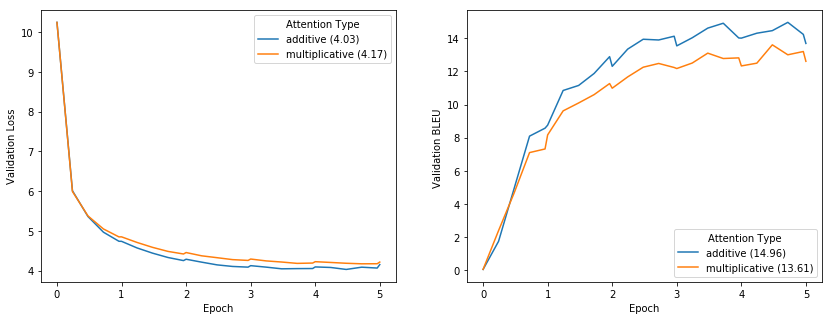

In [15]:
plot_multiple_learning_curves(experiment_results, 'attention_type', 'Attention Type')